## libraries

In [2]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import keras
import tensorflow as tf
import keras.backend as K
from collections import Counter
from tensorflow.python.client import device_lib
from keras.optimizers import Adam, Adamax, SGD
import imutils
import tensorflow_addons as tfa
from keras.models import load_model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)
tf.keras.backend.clear_session()
TF_ENABLE_ONEDNN_OPTS=0
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(tf.device('/gpu:0'))

tf.device('/gpu:0')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-30 13:27:43.897303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 13:27:45.722971: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-12-30 13:27:45.723107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45316 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:19:00.0, compute capability: 8.6


In [4]:
base_path="/home/neel/Acoustic/Acoustics/dataset"
audio_path=os.path.sep.join([base_path,"datachunks"])
annots_path=os.path.sep.join([base_path,"train.csv"])

base_output="/home/neel/Acoustic/Acoustics/output3.0"
test_file=os.path.sep.join([base_output,"test.txt"])

## Generate Spectrograms and labels

In [11]:
print("[INFO] loading dataset...")
rows = open(annots_path).read().strip().split("\n")
spectrogram=np.empty(((len(rows)),257,273,2), dtype="float32")
bounding_box_cords=[]
window_size=int(512)
wd = signal.windows.hamming(window_size)
slide_size = int(4)
overlap = window_size - slide_size
filenames=[]
cnt=0
for row in rows:
    # print(cnt)
    row = row.split(",")
    (filename1,filename2,X, Y, W, H) = row
    channel1_Path = os.path.sep.join([audio_path, filename1])
    channel2_path = os.path.sep.join([audio_path, filename2])
    
    channel1,sample_rate=librosa.load(channel1_Path,sr=None)
    channel2,sample_rate=librosa.load(channel2_path,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')

    # print(image1.shape)
    data=np.stack((spectrum1,spectrum2),axis=-1)
    spectrogram[cnt]=data
    del data,frequency,time
    cnt+=1
    bounding_box_cords.append((X, Y, W, H))
    filenames.append([filename1,filename2])
    # filenames.append(filename1)
print("Done.")

[INFO] loading dataset...
Done.


## Normalize spectrogram

In [12]:
print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))
for i in range(8831):
    min=spectrogram[i].min()
    max=spectrogram[i].max()
    spectrogram[i]= (spectrogram[i]-min)/(max-min)


print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))

Min: 0.000, Max: 0.017
Min: 0.000, Max: 1.000


In [13]:
del channel1,channel2,rows,spectrum1,spectrum2


In [14]:
targets = np.array(bounding_box_cords, dtype="float32")
print(targets.shape)
print(spectrogram.shape)

(8831, 4)
(8831, 257, 273, 2)


## Train - Validation split

In [15]:
split = train_test_split(spectrogram, targets, filenames, test_size=0.10,random_state=42)
del spectrogram, targets, filenames
(trainData, testData) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
del split

print("[INFO] saving testing filenames...")
f = open(test_file, "w")
for i in testFilenames:
    f.write(i[0]+","+i[1])
    f.write("\n")
# f.write("\n".join(testFilenames))
f.close()

print("Training examples: ",trainData.shape)
print("Testing examples: ",testData.shape)

[INFO] saving testing filenames...
Training examples:  (7947, 257, 273, 2)
Testing examples:  (884, 257, 273, 2)


## Model Building

#### VGG

In [35]:
def vgg():
    model = tf.keras.Sequential()
    # Block 1
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv1", input_shape=(257,273,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block1_pool'))

    # Block 2
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv1"))
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block2_pool'))

    # Block 3
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv1"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv2"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block3_pool'))

    # Block 4
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block4_pool'))

    # Block 5
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block5_pool'))

    # FC 
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_1'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_2'))
    model.add(tf.keras.layers.Dense(1024, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_3'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_4'))

    # Output
    model.add(tf.keras.layers.Dense(4, activation='relu', name='output'))

    model.summary()
    return model

#### ANN

In [9]:
def ANN():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(140322,)))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))

    return model
# model=ANN()
# model.summary()

#### 1cnn to dense

In [10]:
def cnn_dense():
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

# cnn_dense().summary()

### Loss Function

In [16]:

def l2_loss_func(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true))


def iou_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)
  x1_true, x2_true, x1_pred, x2_pred= x1_true*1440 , x2_true*1440, x1_pred*1440, x2_pred*1440
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
 
  iou = intersection / (area_true + area_pred - intersection)
  return 1-iou

def combined_loss(y_true, y_pred):
  # Calculate the Smooth L1 loss and IOU loss
  l2_loss = l2_loss_func(y_true, y_pred)
  iou_loss = iou_loss_func(y_true, y_pred)

  # Combine the losses with a weight
  loss = 0 * l2_loss + 1 * iou_loss
  return loss

### Hyps

In [17]:
init_lr=1e-4
epoch=120
batch_size=32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=20,
    decay_rate=0.1,
    staircase=True)
opt = SGD(learning_rate=lr_schedule ,momentum=0.9)


### Model Run

#### VGG 

In [20]:
model=vgg()
model.compile(optimizer=opt, loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

Epoch 1/60


2022-12-29 17:40:56.525652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-29 17:40:58.803178: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


249/249 [==============================] - 67s 218ms/step - loss: 0.4735 - Accuracy: 0.2899 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 2/60
249/249 [==============================] - 51s 205ms/step - loss: 0.4719 - Accuracy: 0.3026 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 3/60
249/249 [==============================] - 51s 206ms/step - loss: 0.4720 - Accuracy: 0.3097 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 4/60
249/249 [==============================] - 50s 201ms/step - loss: 0.4719 - Accuracy: 0.3099 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 5/60
249/249 [==============================] - 50s 201ms/step - loss: 0.4720 - Accuracy: 0.3064 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 6/60
249/249 [==============================] - 50s 201ms/step - loss: 0.4720 - Accuracy: 0.3099 - val_loss: 0.4713 - val_Accuracy: 0.6109
Epoch 7/60
249/249 [==============================] - 49s 198ms/step - loss: 0.4720 - Accuracy: 0.3129 - val_loss: 0.4713 - val_Accuracy: 0.6

[INFO] saving object detector model...


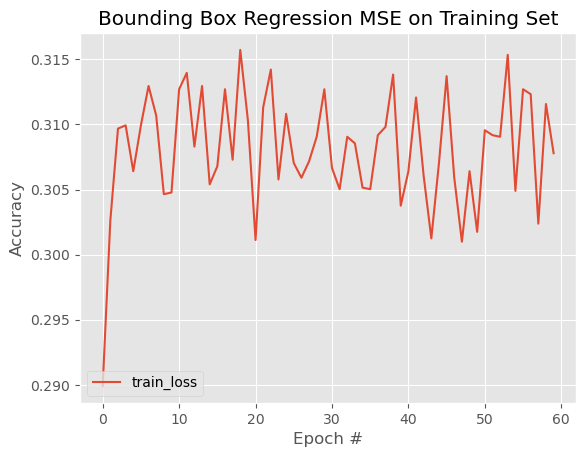

In [25]:
print("[INFO] saving object detector model...")
model.save(base_output+"/vgg.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/vgg.png")

#### ANN

In [12]:
trainData1=trainData.reshape(trainData.shape[0],-1)


In [15]:
model=ANN()
model.compile(optimizer='adam', loss=tfa.losses.GIoULoss(), metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData1, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)


2022-12-29 20:12:41.198463: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:288] gpu_async_0 cuMemAllocAsync failed to allocate 2299035648 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 1321926656/51049857024
2022-12-29 20:12:41.198524: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:293] Stats: Limit:                     20885078016
InUse:                     20753290888
MaxInUse:                  20771776376
NumAllocs:                      445496
MaxAllocSize:               4460555736
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-12-29 20:12:41.198585: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_allocator.cc:56] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2022-12-29 20:12:41.198599: E tensorflow/core/common_runtime/gpu/gpu_cudamallocasync_alloca

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

[INFO] saving object detector model...


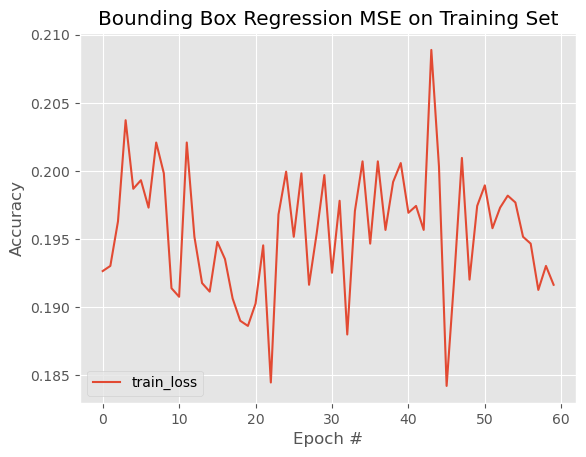

In [62]:
print("[INFO] saving object detector model...")
model.save(base_output+"/ann.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/ann.png")

#### CNN DENSE

In [14]:
model=cnn_dense()
model.compile(optimizer='adam', loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

Epoch 1/120


2022-12-29 21:54:57.716062: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


  1/249 [..............................] - ETA: 16:54 - loss: 0.9998 - Accuracy: 0.1875

2022-12-29 21:54:58.935982: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


249/249 [==============================] - 10s 22ms/step - loss: 0.9969 - Accuracy: 0.2640
Epoch 2/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9955 - Accuracy: 0.3318
Epoch 3/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9946 - Accuracy: 0.3776
Epoch 4/120
249/249 [==============================] - 6s 22ms/step - loss: 0.9918 - Accuracy: 0.4402
Epoch 5/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9895 - Accuracy: 0.5311
Epoch 6/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9881 - Accuracy: 0.5441
Epoch 7/120
249/249 [==============================] - 6s 22ms/step - loss: 0.9841 - Accuracy: 0.6468
Epoch 8/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9808 - Accuracy: 0.6996
Epoch 9/120
249/249 [==============================] - 5s 22ms/step - loss: 0.9773 - Accuracy: 0.7428
Epoch 10/120
249/249 [==============================] - 6s 22ms/step - loss: 0.9746 - Accurac

[INFO] saving object detector model...


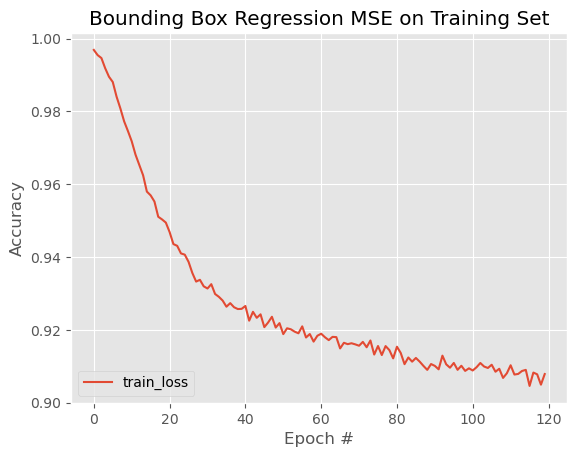

In [15]:
print("[INFO] saving object detector model...")
model.save(base_output+"/cnn_dense.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense.png")

### Testing

In [18]:
model=load_model(base_output+"/cnn_dense.h5", compile=False)
for i,img in enumerate(testFilenames):
    if i==10:
        break
    audioPath1=os.path.sep.join([audio_path, img[0]])
    audioPath2=os.path.sep.join([audio_path, img[1]])
    channel1,sample_rate=librosa.load(audioPath1,sr=None)
    channel2,sample_rate=librosa.load(audioPath2,sr=None)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    spectrum1=np.expand_dims(spectrum1,axis=0)
    spectrum2=np.expand_dims(spectrum2,axis=0)
    spectrogram=np.stack((spectrum1,spectrum2),axis=-1)

    # normalize
    min=spectrogram.min()
    max=spectrogram.max()
    spectrogram= (spectrogram-min)/(max-min)
    preds = model.predict(spectrogram)[0]
    (startX, startY, endX, endY) = preds
    startX,endX=startX*1440, endX*1440
    startY,endY=startY*1080, endY*1080
    width=endX-startX
    height=endY-startY
    f=open("/home/neel/Acoustic/Acoustics/dataset/labels/"+img[0][9:-4]+".txt")
    ground_truth=f.read().replace('\n','').split(" ")
    ground_startX=float(ground_truth[1])
    ground_startY=float(ground_truth[2])
    ground_width=float(ground_truth[3])
    ground_height=float(ground_truth[4])
    ground_startX*=1440
    ground_width*=1440
    ground_startY*=1080
    ground_height*=1080
    print("Image name: ",img[0])
    print("Ground truth: ",ground_startX,ground_startY,ground_width,ground_height)
    print("Predicted: ",startX, startY, width, height)

2022-12-30 14:09:08.621024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 3s 3s/step
Image name:  channel1_4m_train51_3.wav
Ground truth:  801.49968 653.0004 114.99998400000001 72.000036
Predicted:  667.5078392028809 472.6548492908478 207.485990524292 94.81073498725891
1/1 [==============================] - 0s 26ms/step
Image name:  channel1_normal_train119_26.wav
Ground truth:  1024.49952 498.99996 83.000016 50.000004
Predicted:  847.6396751403809 480.4387378692627 313.1906032562256 105.59298992156982
1/1 [==============================] - 0s 18ms/step
Image name:  channel1_5m_train29_23.wav
Ground truth:  144.99936 626.5004399999999 94.00003199999999 54.99997200000001
Predicted:  71.69334948062897 591.2292695045471 145.31381785869598 67.2258996963501
1/1 [==============================] - 0s 19ms/step


2022-12-30 14:09:09.787470: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Image name:  channel1_normal_train40_29.wav
Ground truth:  874.50048 369.5004 114.99998400000001 77.000004
Predicted:  785.5875205993652 458.14555764198303 279.79594230651855 107.93838858604431
1/1 [==============================] - 0s 19ms/step
Image name:  channel1_5m_train44_12.wav
Ground truth:  146.00016000000002 626.0004 92.000016 54.0
Predicted:  94.93494272232056 578.5758519172668 163.2956314086914 69.79425430297852
1/1 [==============================] - 0s 18ms/step
Image name:  channel1_normal_train49_28.wav
Ground truth:  1276.4995199999998 262.00044 108.99993599999999 65.999988
Predicted:  1149.3546295166016 255.12655019760132 218.47566604614258 180.97923159599304
1/1 [==============================] - 0s 18ms/step
Image name:  channel1_3m_train36_26.wav
Ground truth:  299.00016 570.50028 202.00032000000002 104.99997599999999
Predicted:  372.1749973297119 423.05495738983154 241.40160083770752 108.92371416091919
1/1 [==============================] - 0s 19ms/step
Image name:

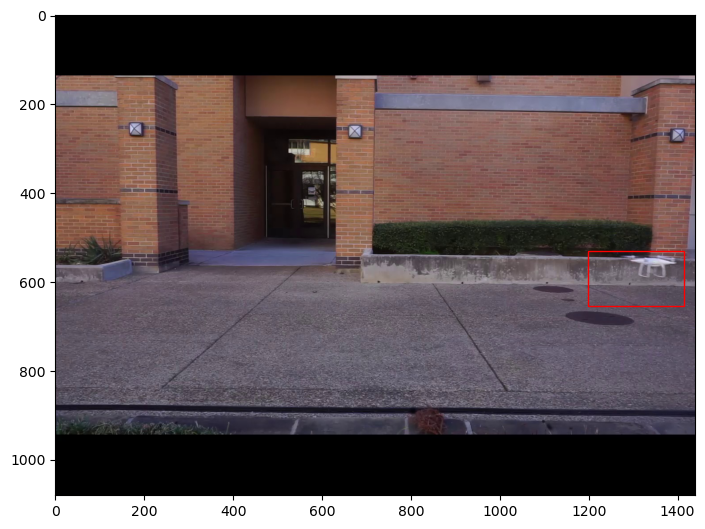

In [20]:
from matplotlib import patches
import matplotlib.pyplot as plt
import cv2

startX,startY, width, height=1199.0357494354248, 529.5778799057007, 214.5912265777588, 122.99610614776611
# X,Y,W,H=625.00032, 617.000274, 162.99936, 96.00001200000001
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/normal_train55_1.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
# rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
# ax.add_patch(rect2)

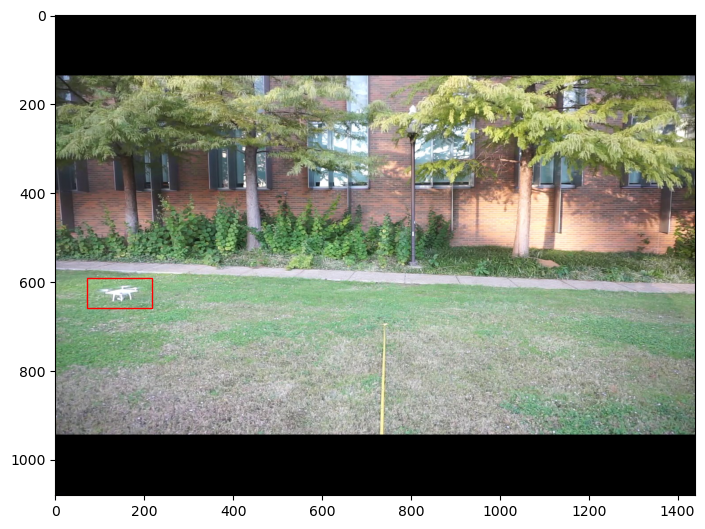

In [21]:
startX,startY, width, height= 71.69334948062897, 591.2292695045471, 145.31381785869598 ,67.2258996963501
# X,Y,W,H=58.5 ,373.99968, 117.0 ,68.00004
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/5m_train29_23.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
# rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
# ax.add_patch(rect2)